<a href="https://colab.research.google.com/github/Berusov/Event_predict/blob/main/%D0%A0%D0%B0%D1%81%D1%87%D0%B5%D1%82_%D0%BE%D1%86%D0%B5%D0%BD%D0%BA%D0%B8_%D1%83%D1%81%D0%BF%D0%B5%D1%88%D0%BD%D0%BE%D1%81%D1%82%D0%B8_%D0%B8_%D0%B0%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7_%D1%80%D0%B5%D0%B7%D1%83%D0%BB%D1%8C%D1%82%D0%B0%D1%82%D0%BE%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Датасет успешно загружен


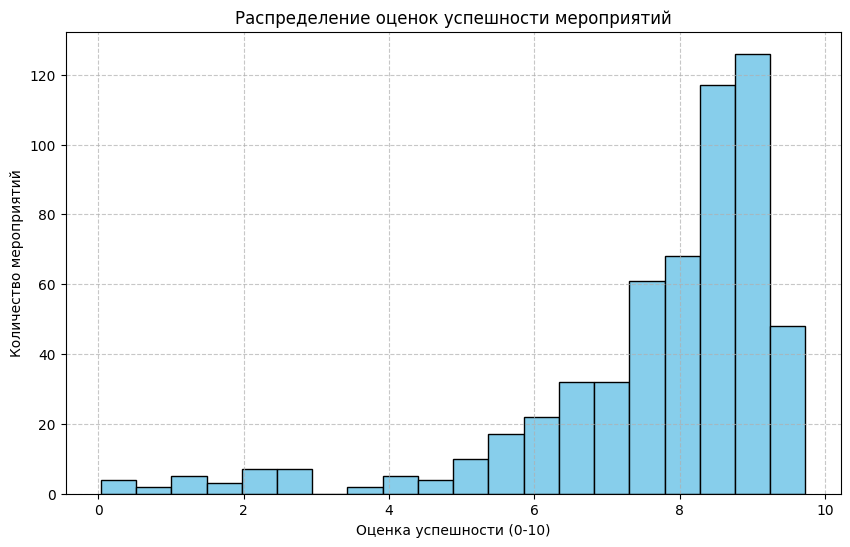


Корреляция параметров с оценкой успешности:
success_score           1.000000
num_items               0.598466
perf_duration           0.598466
audience_size           0.352622
duration                0.279406
award_duration          0.011477
host_speech_duration   -0.229479
Name: success_score, dtype: float64


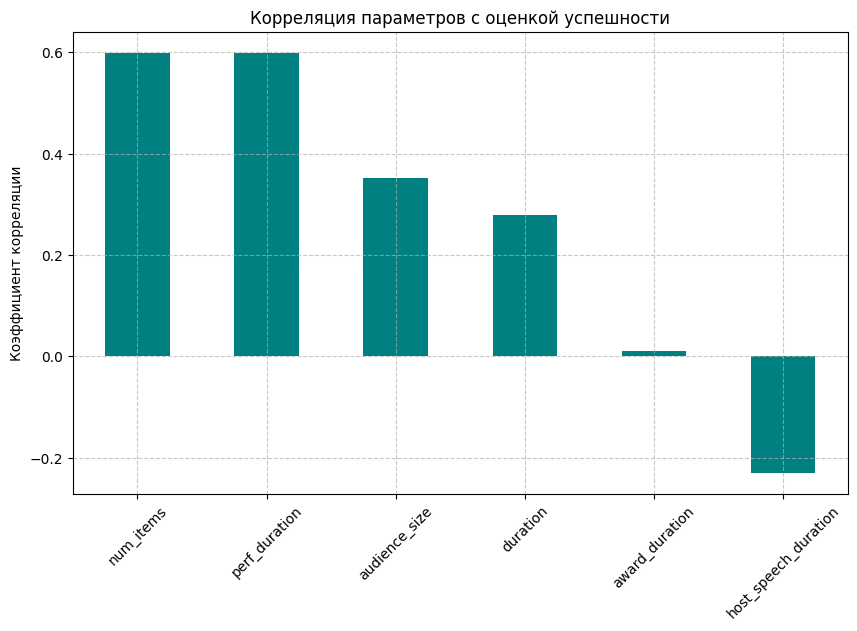


Результаты сохранены в файл: events_hall_dataset_with_scores.csv

Оценка успешности тестового мероприятия: 9.43 из 10


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class EventSuccessModel:
    def __init__(self):
        # Инициализация параметров модели
        self.weights = {
            'w1': 0.3,   # Вес аудитории
            'w2': 0.3,   # Вес количества номеров
            'w3': 0.2,   # Вес длительности выступлений
            'w4': 0.1,   # Вес длительности награждения
            'w5': 0.1    # Вес длительности речи ведущих
        }

        self.params = {
            'nu': 0.25,     # Экспоненциальный коэффициент длительности выступлений
            'mu': 1.2,    # Показатель степенного штрафа для длительности речи ведущих
            'lambda': 1.7,   # Коэффициент взаимодействия
            'gamma': 0.1,     # Коэффициент энтропийной регуляризации
            'D_crit': 0.25,    # Критическое время награждений (доля от общей длительности)
            'max_audience': 1331,    # Максимальный размер аудитории
            'alpha': 5,    # Коэффициент нормировки
            'beta': -0.5    # Коэффициент нормировки
        }

        # Матрица взаимодействия факторов (i,j: 1=AS, 2=NI, 3=PD, 4=AD, 5=HSD)
        self.interaction_matrix = np.array([
            [0, 0.05, 0.05, -0.04, -0.06],
            [0.05, 0, 0, 0.07, 0],
            [0.05, 0, 0, 0.1, 0.05],
            [-0.04, 0.07, 0.1, 0, -0.05],
            [-0.06, 0, 0.05, -0.05, 0]
        ])

    def normalize(self, x):
        """Нормировка в диапазон [0, 1] с помощью сигмоиды"""
        return 1 / (1 + np.exp(-self.params['alpha'] * (x + self.params['beta'])))

    def f1(self, AS):
        """Функция заполненности аудитории"""
        return AS / self.params['max_audience']

    def f2(self, NI):
        """Функция количества номеров"""
        return NI / (NI + 1)

    def f3(self, PD, D):
        """Функция времени выступлений с экспоненциальным ростом"""
        return (PD / D) * (1 - np.exp(-self.params['nu'] * PD))

    def f4(self, AD, D):
        """Функция времени награждений с квадратичным штрафом"""
        return (AD / D) * ( 1 - AD / (D * self.params['D_crit'])) ** 2

    def f5(self, HSD, D):
        """Функция времени ведущих со степенным штрафом"""
        return 1 - (HSD / D) ** self.params['mu']

    def entropy_penalty(self, f_values):
        """Энтропийная регуляризация для баланса факторов"""
        p = f_values / (np.sum(f_values) + 1e-10)
        return -np.sum(p * np.log(p + 1e-10))

    def interaction_effect(self, f_values):
        """Учет взаимодействия факторов"""
        return np.sum(f_values.T @ self.interaction_matrix @ f_values)

    def predict_single(self, x):
        """Предсказание для одного мероприятия"""
        D, AS, AD, NI, PD, HSD = x
        # Проверка и корректировка входных значений
        if D == 0:
            D = 1

        # Вычисление компонентов
        f_values = np.array([
            self.f1(AS),
            self.f2(NI),
            self.f3(PD, D),
            self.f4(AD, D),
            self.f5(HSD, D)
        ])

        # Взвешенная сумма
        linear_part = np.sum([self.weights[f'w{i+1}'] * f_values[i] for i in range(5)])

        # Нелинейные поправки
        interaction = self.params['lambda'] * self.interaction_effect(f_values)
        entropy = self.params['gamma'] * self.entropy_penalty(f_values)

        # Итоговый результат (нормировка через сигмоиду)
        score = linear_part + interaction + entropy
        return 10 * self.normalize(score)

    def predict_dataset(self, df):
        """Добавление оценок для всего датасета"""
        # Проверка наличия нужных колонок
        required_columns = ['duration', 'audience_size', 'award_duration', 'num_items', 'perf_duration', 'host_speech_duration']

        # Вычисление оценок для каждой строки
        df['success_score'] = df.apply(lambda row: self.predict_single([
            row['duration'], row['audience_size'], row['award_duration'],
            row['num_items'], row['perf_duration'], row['host_speech_duration']
        ]), axis=1)

        return df

    def analyze_results(self, df):
        """Анализ и визуализация результатов"""
        # Визуализация распределения оценок
        plt.figure(figsize=(10, 6))
        plt.hist(df['success_score'], bins=20, color='skyblue', edgecolor='black')
        plt.title('Распределение оценок успешности мероприятий')
        plt.xlabel('Оценка успешности (0-10)')
        plt.ylabel('Количество мероприятий')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.show()

        # Корреляция параметров с оценкой успешности
        corr_matrix = df.corr()
        success_corr = corr_matrix['success_score'].sort_values(ascending=False)

        print("\nКорреляция параметров с оценкой успешности:")
        print(success_corr)

        # Визуализация корреляций
        plt.figure(figsize=(10, 6))
        success_corr.drop('success_score').plot(kind='bar', color='teal')
        plt.title('Корреляция параметров с оценкой успешности')
        plt.ylabel('Коэффициент корреляции')
        plt.xticks(rotation=45)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.show()

# Использование с датасетом
if __name__ == "__main__":
        # Загрузка датасета
        url = "https://raw.githubusercontent.com/Berusov/Event_predict/main/events_hall_dataset.csv"
        df = pd.read_csv(url)
        print("Датасет успешно загружен")

        model = EventSuccessModel()
        df = model.predict_dataset(df)

    # Анализ результатов
        model.analyze_results(df)

    # Сохранение результатов
        output_filename = 'events_hall_dataset_with_scores.csv'
        df.to_csv(output_filename, index=False)
        print(f"\nРезультаты сохранены в файл: {output_filename}")

    # Пример предсказания для конкретного мероприятия
        test_event = {
            'duration': 70,
            'audience_size': 1331,
            'award_duration': 20,
            'num_items': 8,
            'perf_duration': 40,
            'host_speech_duration': 10
        }

        test_score = model.predict_single(list(test_event.values()))
        print(f"\nОценка успешности тестового мероприятия: {test_score:.2f} из 10")